# Creating dummy variables

Being able to include categorical features in the model building process can enhance performance as they may add information that contributes to prediction accuracy.

In [14]:
import pandas as pd
music_df = pd.read_csv("dataset/music_clean.csv")

In [8]:

# Create music_dummies
music_dummies = pd.get_dummies(music_df, columns=['genre'], drop_first = True)

# Print the new DataFrame's shape
print("Shape of music_dummies: {}".format(music_dummies.shape))

Shape of music_dummies: (1000, 13)


# Regression with categorical features

Now you have created `music_dummies`, containing binary features for each song's genre, it's time to build a ridge regression model to predict song popularity.

The model will be evaluated by calculating the average RMSE, but first, you will need to convert the scores for each fold to positive values and take their square root. This metric shows the average error of our model's predictions, so it can be compared against the standard deviation of the target value—"`popularity`".

In [4]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge
import numpy as np
# Create X and y
X = music_dummies.drop("popularity", axis = 1).values
y = music_dummies["popularity"].values

# Instantiate a ridge model
ridge = Ridge(alpha = .2)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Perform cross-validation
scores = cross_val_score(ridge, X, y, cv=kf, scoring="neg_mean_squared_error")

# Calculate RMSE
rmse = np.sqrt(-scores)
print("Average RMSE: {}".format(np.mean(rmse)))
print("Standard Deviation of the target array: {}".format(np.std(y)))

Average RMSE: 10.03309869053936
Standard Deviation of the target array: 14.02156909907019


# Dropping missing data

Over the next three exercises, you are going to tidy the `music_df` dataset. You will create a pipeline to impute missing values and build a KNN classifier model, then use it to predict whether a song is of the "`Rock`" genre.

In this exercise specifically, you will drop missing values accounting for less than 5% of the dataset, and convert the "`genre`" column into a binary feature.

In [9]:
# Print missing values for each column
print(music_df.isna().sum().sort_values())


Unnamed: 0          0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
genre               0
dtype: int64


In [10]:

# Remove values where less than 5% are missing
music_df = music_df.dropna(subset=["genre", "popularity", "loudness", "liveness", "tempo"])

# Convert genre to a binary feature
music_df["genre"] = np.where(music_df["genre"] == "Rock", 1, 0)

print(music_df.isna().sum().sort_values())
print("Shape of the `music_df`: {}".format(music_df.shape))

Unnamed: 0          0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
genre               0
dtype: int64
Shape of the `music_df`: (1000, 13)


# Pipeline for song genre prediction: I

Now it's time to build a pipeline. It will contain steps to impute missing values using the mean for each feature and build a KNN model for the classification of song genre.

In [16]:
# Import modules
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
# Instantiate an imputer
imputer = SimpleImputer()

# Instantiate a knn model
knn = KNeighborsClassifier(n_neighbors=3)

# Build steps for the pipeline
steps = [("imputer", imputer), 
         ("knn", knn)]

# Pipeline for song genre prediction: II

Having set up the steps of the pipeline in the previous exercise, you will now use it on the `music_df` dataset to classify the genre of songs. What makes pipelines so incredibly useful is the simple interface that they provide.

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
X = music_df.drop("genre",axis=1).values
y = music_df["genre"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

[[92 12]
 [ 0 96]]


c:\Users\88016\anaconda3\envs\env_py\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


# Centering and scaling for regression

Now you have seen the benefits of scaling your data, you will use a pipeline to preprocess the `music_df` features and build a lasso regression model to predict a song's loudness.

In [20]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

# Create pipeline steps
steps = [("scaler", StandardScaler()),
         ("lasso", Lasso(alpha=0.5))]

# Instantiate the pipeline
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

# Calculate and print R-squared
print(pipeline.score(X_test, y_test))

-0.0025040064102566095


# Centering and scaling for classification

Now you will bring together scaling and model building into a pipeline for cross-validation.

Your task is to build a pipeline to scale features in the `music_df` dataset and perform grid search cross-validation using a logistic regression model with different values for the hyperparameter C. The target variable here is "`genre`", which contains binary values for rock as 1 and any other genre as 0.

In [22]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
# Build the steps
steps = [("scaler", StandardScaler()),
         ("logreg", LogisticRegression())]
pipeline = Pipeline(steps)

# Create the parameter space
parameters = {"logreg__C": np.linspace(0.001, 1.0, 20)}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=21)

# Instantiate the grid search object
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training data
cv.fit(X_train, y_train)
print(cv.best_score_, "\n", cv.best_params_)

0.9275 
 {'logreg__C': 0.5793684210526315}


# Visualizing regression model performance

Now you have seen how to evaluate multiple models out of the box, you will build three regression models to predict a song's "`energy`" levels.

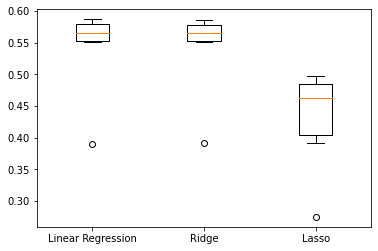

In [25]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
models = {"Linear Regression": LinearRegression(), "Ridge": Ridge(alpha=0.1), "Lasso": Lasso(alpha=0.1)}
results = []

# Loop through the models' values
for model in models.values():
  kf = KFold(n_splits=6, random_state=42, shuffle=True)
  
  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
  
  # Append the results
  results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, labels=models.keys())
plt.show()

# Predicting on the test set

In the last exercise, linear regression and ridge appeared to produce similar results. It would be appropriate to select either of those models; however, you can check predictive performance on the test set to see if either one can outperform the other.

You will use root mean squared error (RMSE) as the metric

In [26]:
# Import mean_squared_error
from sklearn.metrics import mean_squared_error

for name, model in models.items():
  
  # Fit the model to the training data
  model = model.fit(X_train, y_train) # X_train_scaled
  
  # Make predictions on the test set
  y_pred = model.predict(X_test) # X_test_scaled
  
  # Calculate the test_rmse
  test_rmse = mean_squared_error(y_test, y_pred, squared=False)
  print("{} Test Set RMSE: {}".format(name, test_rmse))

Linear Regression Test Set RMSE: 0.3434546524072736
Ridge Test Set RMSE: 0.34334299017652053
Lasso Test Set RMSE: 0.3786246184767724


# Visualizing classification model performance

In this exercise, you will be solving a classification problem where the "`popularity`" column in the `music_df` dataset has been converted to binary values, with 1 representing popularity more than or equal to the median for the "`popularity`" column, and 0 indicating popularity below the median.

Your task is to build and visualize the results of three different models to classify whether a song is popular or not.

c:\Users\88016\anaconda3\envs\env_py\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\88016\anaconda3\envs\env_py\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

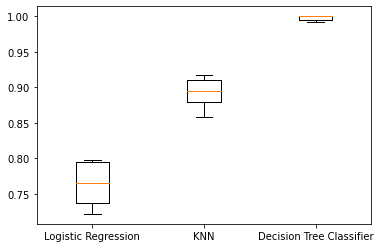

In [27]:
from sklearn.tree import DecisionTreeClassifier
# Create models dictionary
models = {"Logistic Regression": LogisticRegression(), "KNN": KNeighborsClassifier(), "Decision Tree Classifier": DecisionTreeClassifier()}
results = []

# Loop through the models' values
for model in models.values():
  
  # Instantiate a KFold object
  kf = KFold(n_splits=6, random_state=12, shuffle=True)
  
  # Perform cross-validation
  cv_results = cross_val_score(model, X_train, y_train, cv=kf) # X_train_scaled
  results.append(cv_results)
plt.boxplot(results, labels=models.keys())
plt.show()

# Pipeline for predicting song popularity

For the final exercise, you will build a pipeline to impute missing values, scale features, and perform hyperparameter tuning of a logistic regression model. The aim is to find the best parameters and accuracy when predicting song genre!

All the models and objects required to build the pipeline have been preloaded for you

In [28]:
# Create steps
steps = [("imp_mean", SimpleImputer()), 
         ("scaler", StandardScaler()), 
         ("logreg", LogisticRegression())]

# Set up pipeline
pipeline = Pipeline(steps)
params = {"logreg__solver": ["newton-cg", "saga", "lbfgs"],
         "logreg__C": np.linspace(0.001, 1.0, 10)}

# Create the GridSearchCV object
tuning = GridSearchCV(pipeline, param_grid=params)
tuning.fit(X_train, y_train)
y_pred = tuning.predict(X_test)

# Compute and print performance
print("Tuned Logistic Regression Parameters: {}, Accuracy: {}".format(tuning.best_params_, tuning.score(X_test, y_test)))

Tuned Logistic Regression Parameters: {'logreg__C': 0.556, 'logreg__solver': 'newton-cg'}, Accuracy: 0.88
